In [2]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import wandb
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZES = [100, 100]

In [4]:
# reads all images in filepath, resizes it according with 2D list img_sizes and 
# store them in a np_array. The string filepath can only contain images (no other
# file types such as txt for example are allowed). 
# It works only for RGB images.
def images_to_np_array(filepath, img_sizes):
    """
    This function reads all imagens in a given folder, resizes them and stores them in a numpy array.

    Parameters:
    filepath (str): The path to the folder containing the images.
    img_sizes (list): A list containing the desired height and width of the images.

    Returns:
    np.ndarray: A numpy array containing all the images resized to the specified dimensions.
    """
    
    list_of_files = []

    for dirpath, _, filenames in os.walk(filepath):
        for f in filenames:
            full_path = os.path.join(dirpath, f)
            list_of_files.append(full_path)

    # number of image files
    n_images = len(list_of_files)

    # create np_array to store all images
    array_images = np.zeros((n_images, img_sizes[1], img_sizes[0], 3), dtype=np.uint8)

    for index, image_path in enumerate(list_of_files):
        with Image.open(image_path) as img:
            img_rgb = img.convert('RGB')
            img_resized = img_rgb.resize(img_sizes)
            array_images[index] = np.asarray(img_resized)

    return array_images

In [5]:
# reads multiple folders, each one containing images from one class, divided in a folder containing 
# all training images and another folder containing all test images
def read_folders_multiclass(list_of_folders, img_sizes):
    #-----------------------------------------------------------------------------
    # Args:
    #     list_of_folders:      String with the path to the directories containing 
    #                           the images. Each directory corresponds to a class
    #                           in 2 folders names train and test. Ex.: for k classes,
    #                           list_of_folders = ["dir_class_1", ... "dir_class_k"]
    #                           
    #                           dir_class_1/
    #                                 train/
    #                                 test/
    #                           dir_class_2/
    #                                 train/
    #                                 test/
    #                           .
    #                           .
    #                           .
    #                           dir_class_k/
    #                                 train/
    #                                 test/
    #
    #                           list_of_folders CANNOT end with the / character.
    #
    #     img_sizes: 2D array [num_rows, num_columns].
    #-----------------------------------------------------------------------------

    # number of classes
    n_classes = len(list_of_folders)
    k = 0
    
    # training data
    x_train = images_to_np_array(filepath = list_of_folders[0] + "/train", img_sizes = IMAGE_SIZES)
    y_train = np.zeros(x_train.shape[0])

    # test data
    x_test = images_to_np_array(filepath = list_of_folders[0] + "/test", img_sizes = IMAGE_SIZES)
    y_test = np.zeros(x_test.shape[0])

    for k in range(1, n_classes):
            
        # read train
        x_train_k = images_to_np_array(filepath = list_of_folders[k] + "/train", img_sizes = IMAGE_SIZES)
        y_train_k = np.zeros(x_train_k.shape[0]) + k

        # concatenate X and y with the current vectors
        x_train = np.concatenate( (x_train, x_train_k) )
        y_train = np.concatenate( (y_train, y_train_k) ) 

        # read test
        x_test_k = images_to_np_array(filepath = list_of_folders[k] + "/test", img_sizes = IMAGE_SIZES)
        y_test_k = np.zeros(x_test_k.shape[0]) + k

        # concatenate X and y with the current vectors
        x_test = np.concatenate( (x_test, x_test_k) )
        y_test = np.concatenate( (y_test, y_test_k) ) 


    # shuffle the data
    number_of_images = len(y_train)
    permuted_index = np.random.permutation(number_of_images)

    # training data
    x_train = x_train[permuted_index, :, :, :]
    y_train = y_train[permuted_index]

    return {"x_train": x_train,
            "y_train": y_train,
            "x_test": x_test,
            "y_test": y_test}




In [6]:
# read image data
data_dict = read_folders_multiclass(list_of_folders=["./burro", "./capivara"], img_sizes=IMAGE_SIZES)


In [7]:
# extracting training data
y_train = data_dict["y_train"]
x_train = data_dict["x_train"]

# extracting test data
y_test = data_dict["y_test"]
x_test = data_dict["x_test"]


In [8]:
# preprocessing 
x_train = tf.keras.applications.densenet.preprocess_input(x_train, data_format = "channels_last")
x_test = tf.keras.applications.densenet.preprocess_input(x_test, data_format = "channels_last")


In [9]:

# initialize model with weights treined in imagenet 
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZES[0], IMAGE_SIZES[1], 3),
    pooling="avg",
    classes=2,
    classifier_activation="None"
)

# Freeze model weights
base_model.trainable = False

In [10]:
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.5),]
)

In [11]:
inputs = tf.keras.Input(shape=(IMAGE_SIZES[0], IMAGE_SIZES[1], 3))
# apply data augmentation
x = data_augmentation(inputs)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.Flatten(data_format = "channels_last")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
x = tf.keras.layers.Dense(100, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 1664)           │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       166,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,829,681 (48.94 MB)

 Trainable params: 186,801 (729.69 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [12]:
#checkpoint_filepath = "./trained_model_checkpoint"

# define the callback (to save the weights that gave best val_accuracy during training)
#callback = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy',
#                                              mode = "max",
#                                              save_best_only = True,
#                                              filepath = checkpoint_filepath)


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

history = model.fit(x = x_train, 
                    y = y_train, 
                    epochs = 50, 
                    validation_data = (x_test, y_test), 
                    batch_size = 100)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - binary_accuracy: 0.3547 - loss: 0.7690 - val_binary_accuracy: 0.5300 - val_loss: 0.7681
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - binary_accuracy: 0.6622 - loss: 0.6227 - val_binary_accuracy: 0.6350 - val_loss: 0.7119
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - binary_accuracy: 0.7144 - loss: 0.5659 - val_binary_accuracy: 0.7800 - val_loss: 0.5589
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - binary_accuracy: 0.7885 - loss: 0.4757 - val_binary_accuracy: 0.8900 - val_loss: 0.4435
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - binary_accuracy: 0.8163 - loss: 0.4381 - val_binary_accuracy: 0.9100 - val_loss: 0.3698
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - binary_accuracy: 0.8073 - loss: 0.3969 - val_binary_accuracy: 0.9250 - val_loss: 0.3386
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - binary_accuracy: 0.8916 - loss: 0.3539 - val_binary_accuracy: 0.9400 - val_loss: 0.2842
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1

In [14]:
model.evaluate(y = y_test, x = x_test, verbose = 2)

7/7 - 14s - 2s/step - binary_accuracy: 0.9500 - loss: 0.1241


[0.12412683665752411, 0.949999988079071]

In [15]:
predictions = model.predict(x_test)
pd.DataFrame( {"probability": tf.keras.activations.sigmoid(predictions)[:,0], "label": y_test})

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step 


,probability,label
0,0.001286,0.0
1,0.000148,0.0
2,0.000057,0.0
3,0.031110,0.0
4,0.004830,0.0
...,...,...
195,0.995460,1.0
196,0.998726,1.0
197,0.981210,1.0
198,0.341711,1.0


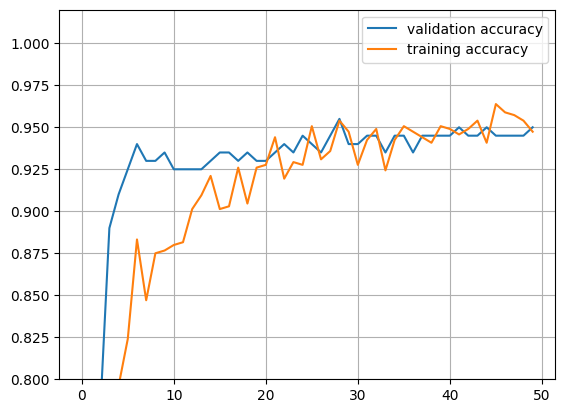

In [16]:
plt.plot( history.history['val_binary_accuracy'], label='validation accuracy')
plt.plot( history.history['binary_accuracy'], label = 'training accuracy')
plt.ylim([0.8, 1.02])
plt.grid()
plt.legend()
plt.show()

In [17]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history_2 = model.fit(x = x_train, y = y_train, epochs=epochs, validation_data = (x_test, y_test))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 1664)           │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       166,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,203,285 (50.37 MB)

 Trainable params: 12,671,281 (48.34 MB)

 Non-trainable params: 158,400 (618.75 KB)

 Optimizer params: 373,604 (1.43 MB)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - binary_accuracy: 0.7533 - loss: 0.4003 - val_binary_accuracy: 0.9450 - val_loss: 0.1218
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - binary_accuracy: 0.8548 - loss: 0.3096 - val_binary_accuracy: 0.9500 - val_loss: 0.1209
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - binary_accuracy: 0.8698 - loss: 0.3091 - val_binary_accuracy: 0.9500 - val_loss: 0.1171
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - binary_accuracy: 0.9188 - loss: 0.2481 - val_binary_accuracy: 0.9550 - val_loss: 0.1229
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - binary_accuracy: 0.9161 - loss: 0.2326 - val_binary_accuracy: 0.9550 - val_loss: 0.1253
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - binary_accuracy: 0.9442 - loss: 0.1882 - val_binary_accuracy: 0.9550 - val_loss: 0.1282
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - binary_accuracy: 0.9693 - loss: 0.1698 - val_binary_accuracy: 0.9600 - val_loss: 0.1215
Epoch 8/50
19/19 ━━

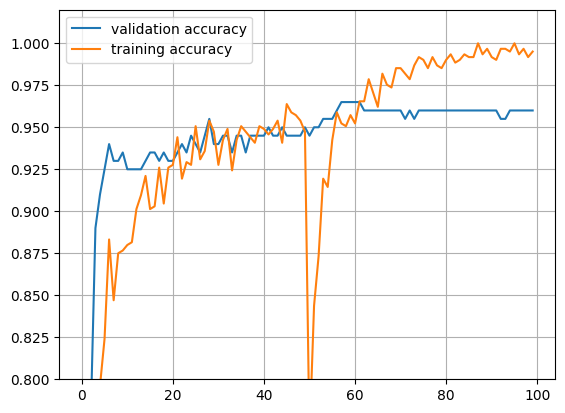

In [18]:

# concatenate results from the 2 training steps
val_acc = np.concatenate( (history.history['val_binary_accuracy'], history_2.history['val_binary_accuracy']) )
acc = np.concatenate( (history.history['binary_accuracy'], history_2.history['binary_accuracy']) )


plt.plot( val_acc, label='validation accuracy')
plt.plot( acc, label = 'training accuracy')
plt.ylim([0.8, 1.02])
plt.grid()
plt.legend()
plt.show()